### 1. State Reducer
- Reducer는 LangGraph에서 상태 업데이트를 관리하는 중요한 개념
- 그래프의 각 노드의 출력을 그래프의 상태에 통합하는 방법을 정의
- Reducer의 필요성
    - 상태 덮어쓰기 문제: 기본적으로 각 노드의 반환값은 해당 상태 키의 이전 값을 덮어쓰는 방식으로 동작 (override)
    - 누적 업데이트 필요: 특히 메시지 리스트와 같은 경우, 이전 상태에 새로운 값을 추가하고 싶을 때가 있음 

`(1) Reducer를 별도로 지정하지 않은 경우 `
- reducer를 별도로 지정하지 않은 경우 기존 값을 덮어쓰는 방식으로 동작
- 기본 reducer는 상태에 대해 별도의 설정 없이 사용될 때 자동으로 적용

In [1]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END

# 상태 정의 
class DocumentState(TypedDict):
    query: str
    documents: List[str]

# Node 1: query 업데이트
def node_1(state: DocumentState) -> DocumentState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가 
def node_2(state: DocumentState) -> DocumentState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: DocumentState) -> DocumentState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}


# 그래프 빌드
builder = StateGraph(DocumentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()



In [2]:
#from IPython.display import Image, display
# 그래프 시각화
#display(Image(graph.get_graph().draw_mermaid_png()))

mermaid_code = graph.get_graph().draw_mermaid()
print("Mermaid Code:")
print(mermaid_code)

Mermaid Code:
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	node_1(node_1)
	node_2(node_2)
	node_3(node_3)
	__end__([<p>__end__</p>]):::last
	__start__ --> node_1;
	node_1 --> node_2;
	node_2 --> node_3;
	node_3 --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



* https://mermaid.live/ 에서  mermain_code 로 직접 확인한다.

* [Graph이미지](https://www.mermaidchart.com/play?utm_source=mermaid_live_editor&utm_medium=share#pako:eNp9j0EKgzAQRa8S7EahtppAF1FceYTuapGoGQ0EFU0XpfTujYkkuOlqZt78-T_5BO3U8YAG_cLmAd3LrBorVderYosu4SOfCzfl17l4RpRSEMuqNuGoj-s0tCVyBFuCPSGWkMja87Fz5qZ31pJZZxeK4rhANiDzkZ5iT7GnxFNi6J5jcKtD1pID6jiwl1QIhJT0BBgSgLMUI48HLvpB0fSCDwfm40YeTzNrhXrT5CDYnr_bNdDcoNXbv_vg-wPTVIcO)

In [3]:
# 질문
initial_state = {"query": "Reducer를 사용하지 않은 경우"}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("최종 상태:", final_state)

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---
최종 상태: {'query': 'Reducer를 사용하지 않은 경우', 'documents': ['doc2.pdf', 'doc4.pdf', 'doc5.pdf']}


`(2) Reducer를 별도로 지정하는 경우 `
- `Annotated` 사용하여 지정한 reducer 작동 방식에 따라 기존 상태 정보를 업데이트 
- 리스트를 병합하는 `operator.add`를 사용하면, activity_log를 누적하는 방식으로 노드를 구현
- add 함수는 자체로 리스트를 병합하는 동작을 수행하지만, 이 동작이 LangGraph의 상태 병합 규칙으로 통합되려면 Annotated를 통해 해당 타입에 연결되어야 합니다. 

In [4]:
from operator import add # 항목들을 더하는 연산자(함수). 여기서는 리스트에 항목을 추가하는 용도로 사용됩니다.
from typing import Annotated, TypedDict # 타입 힌트에 메타데이터를 추가하는 Annotated와 딕셔너리 타입을 정의하는 TypedDict를 가져옵니다.
from langgraph.graph import StateGraph, START, END # LangGraph의 핵심 클래스들을 가져옵니다.

# ReducerState는 LangGraph의 에이전트 상태를 정의합니다.
# TypedDict를 사용하여 딕셔너리가 어떤 키와 값 타입을 가져야 하는지 명확하게 지정합니다.
class ReducerState(TypedDict):
    # 'query' 키는 단순 문자열 타입입니다.
    query: str
    # 'documents' 키는 문자열 리스트입니다.
    # 여기서 Annotated가 핵심 역할을 합니다. add를 메타데이터로 사용하여,
    # 'documents'에 새로운 리스트가 반환될 때마다 기존 리스트에 그 내용을
    # **추가(extend)**하도록 LangGraph에 지시합니다. 즉, 덮어쓰지 않습니다.
    documents: Annotated[List[str], add]

# Node 1: query 업데이트
# 이 함수는 에이전트의 첫 번째 노드 역할을 합니다.
def node_1(state: ReducerState) -> ReducerState:
    print("---Node 1 (query update)---")
    # 현재 상태에서 'query'를 가져와 반환합니다. 이 단계에서는 'documents'는 비어 있습니다.
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가
# 이 함수는 첫 번째 문서 세트를 반환합니다.
def node_2(state: ReducerState) -> ReducerState:
    print("---Node 2 (add documents)---")
    # 'documents' key에 리스트를 반환합니다.
    # Annotated[..., add] 지시 덕분에 이 리스트가 기존 'documents'에 추가됩니다.
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
# 이 함수는 두 번째 문서 세트를 반환합니다.
def node_3(state: ReducerState) -> ReducerState:
    print("---Node 3 (add more documents)---")
    # 'documents' 키에 또 다른 리스트를 반환합니다.
    # 이 리스트도 기존 'documents'에 추가됩니다.
    # 최종적으로 'documents'에는 두 노드에서 반환된 모든 문서가 포함됩니다.
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}

# 그래프 빌드
builder = StateGraph(ReducerState)
# 세 개의 노드를 그래프에 추가합니다.
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성 (그래프의 흐름을 정의)
# START에서 'node_1'로 시작합니다.
builder.add_edge(START, "node_1")
# 'node_1'에서 'node_2'로 진행합니다.
builder.add_edge("node_1", "node_2")
# 'node_2'에서 'node_3'으로 진행합니다.
builder.add_edge("node_2", "node_3")
# 'node_3'에서 END로 종료합니다.
builder.add_edge("node_3", END)

# 그래프 실행을 위해 컴파일합니다.
graph = builder.compile()

# 만약 이 그래프를 실행하면,
# 'documents'의 최종 상태는 ["doc1.pdf", "doc2.pdf", "doc3.pdf", "doc2.pdf", "doc4.pdf", "doc5.pdf"]가 됩니다.

In [5]:
# 초기 상태
initial_state = {"query": "Reducer를 사용한 경우"}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("최종 상태:", final_state)

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---
최종 상태: {'query': 'Reducer를 사용한 경우', 'documents': ['doc1.pdf', 'doc2.pdf', 'doc3.pdf', 'doc2.pdf', 'doc4.pdf', 'doc5.pdf']}


`(3) Custom Reducer 사용 `
- 상태 업데이트가 기본적인 덮어쓰기나 병합만으로 해결되지 않을 때 유용한 방법
- 중복 제거, 최대/최소 값 유지, 조건부 병합 등의 특정 비즈니스 로직이 필요한 경우에 적용
- **커스텀 병합 함수(custom reducer)**를 사용하여 노드 간에 상태를 효율적으로 전달하는 방법을 보여줍니다. 
- Annotated를 사용해 특정 필드(documents)의 병합 방식을 기본 덮어쓰기 방식 대신 직접 정의한 함수로 지정합니다.

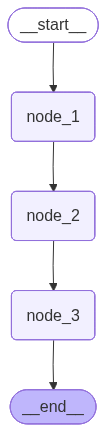

In [6]:
from typing import TypedDict, List, Annotated

# operator.add 대신 사용할 커스텀 병합 함수를 정의합니다.
# 이 함수는 두 리스트를 합치고 중복된 항목을 제거합니다.
def reduce_unique_documents(left: list | None, right: list | None) -> list:
    """두 문서 리스트를 합치고 중복을 제거합니다."""
    # left 또는 right가 None이면 빈 리스트로 초기화합니다.
    if not left:
        left = []
    if not right:
        right = []
    # 두 리스트를 합친 후, set으로 변환하여 중복을 제거하고 다시 리스트로 반환합니다.
    return list(set(left + right))

# LangGraph의 상태를 정의합니다.
class CustomReducerState(TypedDict):
    query: str
    # 'documents' 필드는 문자열 리스트입니다.
    # Annotated를 사용하여 이 필드에 새로운 값이 들어올 때,
    # 위에서 정의한 'reduce_unique_documents' 함수를 사용해
    # 기존 값과 새로운 값을 병합하도록 지시합니다.
    documents: Annotated[List[str], reduce_unique_documents]

# --- LangGraph 노드 정의 ---
# 이 노드들은 에이전트의 각 단계를 나타냅니다.
# Node 1: 쿼리를 업데이트합니다.
def node_1(state: CustomReducerState) -> CustomReducerState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 첫 번째 문서 세트를 상태에 추가합니다.
def node_2(state: CustomReducerState) -> CustomReducerState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 두 번째 문서 세트를 상태에 추가합니다.
# 이 노드에서 반환된 "doc2.pdf"는 이미 존재하므로,
# reduce_unique_documents 함수에 의해 자동으로 제거됩니다.
def node_3(state: CustomReducerState) -> CustomReducerState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}

# 그래프를 구성합니다.
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 그래프의 실행 흐름을 정의합니다.
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 최종 그래프를 컴파일합니다.
# 이 그래프를 실행하면, documents 필드는 노드 2와 3에서 반환된 모든 문서를 포함하되,
# 중복된 "doc2.pdf"는 제거됩니다.
graph = builder.compile()
graph

In [7]:
# 그래프 시각화
#display(Image(graph.get_graph().draw_mermaid_png()))

mermaid_code = graph.get_graph().draw_mermaid()
print("Mermaid Code:")
print(mermaid_code)

Mermaid Code:
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	node_1(node_1)
	node_2(node_2)
	node_3(node_3)
	__end__([<p>__end__</p>]):::last
	__start__ --> node_1;
	node_1 --> node_2;
	node_2 --> node_3;
	node_3 --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



* https://mermaid.live/ 에서  mermain_code 로 직접 확인한다.

* [Graph이미지](https://mermaidchart.com/play?utm_source=mermaid_live_editor&utm_medium=share#pako:eNpVkcFugzAMhl8FeZdWghacQmha9bI-wk4bU5VCUpAgoBCkdVXffWnoQD3Z_mT_v53cIG8LAQwumnel93HcZSozp1NvuLZh8bXvDlO1X3eH7yVjTFa6N49GZYdP0WIMy4ngSHAmZCRkOcoLVUziLp-kaz4qT6ZeEBy80WA3W84UZ4ozJTMljj59HM6tSX8U0iuE5ENtPFnVNXuTKEMp_bpSIihFdSkNi1b4MuAOd-1B2_G8MlcWvjQ81n_KneU5kTn49mmrApjkdS98aIRu-KOGW6Y8LwNTikZkwGz6XCeDTN3tXMfVZ9s2wIwe7KRuh0v5XwxdwY04Vtz-WzOJa3uj0O_toAwwjKnTAHaDH2DU3kJJiDHZJhHZbGMfrsCiTbpKE0y3GKdkQzG9-_DrTMMVpQQpYpQQDENC0_sffQK3NA)

In [8]:
# 초기 상태
initial_state = {"query": "채식주의자를 위한 비건 음식을 추천해주세요.", "documents": []}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("최종 상태:", final_state)

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---
최종 상태: {'query': '채식주의자를 위한 비건 음식을 추천해주세요.', 'documents': ['doc3.pdf', 'doc2.pdf', 'doc1.pdf', 'doc5.pdf', 'doc4.pdf']}


#### 2. MessageGraph 역할
* MessageGraph는 **채팅 및 대화형 애플리케이션**을 구축하는 데 특화된 그래프 클래스입니다. 
    * 일반적인 StateGraph가 딕셔너리 기반의 상태를 관리하는 반면, MessageGraph는 대화의 흐름을 나타내는 **메시지 목록(list[messages])**을 핵심 상태로 사용합니다. 
    * 이를 통해 사용자와 AI 간의 상호작용을 자연스럽게 모델링하고 관리할 수 있습니다.

* MessageGraph는 다음과 같은 주요 기능을 제공합니다.
    * 메시지 기반 상태 관리: 상태를 messages라는 키를 가진 리스트로 자동 설정하여, 사용자와 AI의 대화 기록을 손쉽게 추적할 수 있습니다.
    * MessageGraph는 대화 상태를 자동으로 messages 리스트로 관리하므로, 각 노드 함수는 새로운 메시지를 반환하기만 하면 됩니다.
    * 자동 병합: 각 노드에서 새로운 메시지 목록을 반환하면, MessageGraph는 이를 기존 메시지 목록에 자동으로 추가(append)합니다. 
        * 이는 StateGraph에서 Annotated와 add를 사용해 수동으로 구현해야 했던 기능을 기본적으로 제공합니다.
    * 대화 중심 흐름: 대화형 에이전트의 작동 방식을 직관적으로 표현합니다. 한 노드에서 사용자 메시지를 처리하고, 다른 노드에서 AI 응답을 생성하는 등 대화의 각 단계를 명확하게 구분할 수 있습니다.

`(1) Messages State 정의`
- 이전 대화 기록을 그래프 상태에 메시지 목록으로 저장하는 것이 유용
- 그래프 상태에 Message 객체 목록을 저장하는 키(채널)를 추가하고, 이 키에 리듀서 함수를 추가 
- 리듀서 함수 선택:
    - operator.add를 사용하면: 새 메시지를 기존 목록에 단순히 추가
    - add_messages 함수를 사용하면:
        - 새 메시지는 기존 목록에 추가
        - 기존 메시지 업데이트도 올바르게 처리 (메시지 ID를 추적)
```python
class MessageState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]        
```    

##### 1) 기본 State 초기화 방법을 사용

In [9]:
from typing import Annotated,TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# 기본 State 초기화 방법을 사용
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

##### 2) MessagesState 상태 객체를 사용

In [10]:
# LangGraph MessagesState라는 미리 만들어진 상태를 사용
from langgraph.graph import MessagesState
from typing import List
from langchain_core.documents import Document

class GraphState(MessagesState):
    # messages key는 기본적으로 제공 - 다른 키를 추가하고 싶을 경우 아래 주석과 같이 적용 가능 
    documents: List[Document]
    grade: float
    num_generation: int

In [11]:
from dotenv import load_dotenv
import os

# .env 파일을 불러와서 환경 변수로 설정
load_dotenv()

UPSTAGE_API_KEY = os.getenv("UPSTAGE_API_KEY")
print(UPSTAGE_API_KEY[30:])

z6


In [12]:
from langchain_upstage import ChatUpstage

llm = ChatUpstage(
        model="solar-pro",
        base_url="https://api.upstage.ai/v1",
        temperature=0.5
    )
print(llm.model_name)

c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\mylangchain-app-SBe-Yh6W-py3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


solar-pro


##### 기본적인 MessagesState 사용

* state["messages"]는 메시지 객체들의 리스트입니다:
    ```python
        state["messages"] = [
            HumanMessage(content="첫 번째 질문"),
            AIMessage(content="첫 번째 답변"), 
            HumanMessage(content="두 번째 질문")
        ]
    ```
* 별표(*) 없이 사용하면 발생하는 문제    
    ```python
        # 잘못된 사용법 - 리스트를 그대로 전달
        prompt = ChatPromptTemplate.from_messages([
            ("system", "시스템 메시지"),
            state["messages"]  # 리스트 전체를 하나의 요소로 전달
        ])

        # 이렇게 되면 실제 구조는:
        [
            ("system", "시스템 메시지"),
            [  # 중첩된 리스트가 생성됨
                HumanMessage(content="첫 번째 질문"),
                AIMessage(content="첫 번째 답변"),
                HumanMessage(content="두 번째 질문")
            ]
        ]

    ```
 * 대안
 
    ```python
        prompt = ChatPromptTemplate.from_messages([
            ("system", "시스템 메시지") + state["messages"]
        ])

 * 별표(*) 를 사용한 올바른 방법
    * 별표(*)는 ECMAScript의 펼침연산자와 동일한 역할로 생각하면 됩니다.
    ```python
        # 잘못된 사용법 - 리스트를 그대로 전달
        prompt = ChatPromptTemplate.from_messages([
            ("system", "시스템 메시지"),
            state["messages"]  # 리스트 전체를 하나의 요소로 전달
        ])

        # 이렇게 되면 실제 구조는:
        [
            ("system", "시스템 메시지"),
            HumanMessage(content="첫 번째 질문"),
            AIMessage(content="첫 번째 답변"),
            HumanMessage(content="두 번째 질문")
        ]
    ```


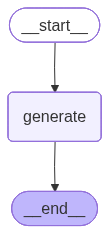

In [13]:
from typing import Dict, Any
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate

# AI 응답 생성 노드 - MessagesState를 반환 타입으로 사용
def generate_response(state: MessagesState) -> MessagesState:
    # 시스템 프롬프트와 메시지 기록을 결합
    # MessagesState는 messages 필드를 자동으로 가지고 있습니다
    prompt = ChatPromptTemplate.from_messages([
        ("system", "당신은 친절한 AI 어시스턴트입니다. 사용자의 질문에 친절하게 답변해주세요."),
        *state["messages"]  # MessagesState는 이미 메시지 객체를 포함하고 있음
    ])
    
    # 체인 생성
    chain = prompt | llm
    
    # 응답 생성
    response = chain.invoke({})
    
    # 새로운 메시지를 상태에 추가 (MessagesState 타입으로 반환)
    return {"messages": [response]}

# 그래프 빌더 생성 - MessagesState 사용
graph_builder = StateGraph(MessagesState)

# 노드 추가
graph_builder.add_node("generate", generate_response)

# 엣지 설정
graph_builder.add_edge(START, "generate")
graph_builder.add_edge("generate", END)

# 그래프 컴파일
app = graph_builder.compile()

app

In [ ]:

# 실행 예제
if __name__ == "__main__":
    # 초기 메시지로 그래프 실행
    # MessagesState는 딕셔너리처럼 초기화합니다
    initial_state = {"messages": [HumanMessage(content="안녕하세요! 오늘 날씨가 어때요?")]}
    result = app.invoke(initial_state)
    print(result)
    
    print("AI 응답:", result["messages"][-1].content)
    

    # 대화 계속 이어가기
    next_state = {
        "messages": [
            HumanMessage(content="안녕하세요! 오늘 날씨가 어때요?"),
            result["messages"][-1],
            HumanMessage(content="서울 날씨는 specifically 어떻게 될까요?")
        ]
    }
    
    next_result = app.invoke(next_state)
    print("두 번째 AI 응답:", next_result["messages"][-1].content)

{'messages': [HumanMessage(content='안녕하세요! 오늘 날씨가 어때요?', additional_kwargs={}, response_metadata={}, id='c541c661-2459-4878-b1cb-93656a4ca63e'), AIMessage(content='안녕하세요! 😊  \n오늘 날씨에 대해 궁금하시군요.  \n\n하지만 저는 실시간으로 날씨 정보를 확인할 수 없어 현재 날씨를 바로 알려드리기 어렵습니다.  \n대신 **날씨 앱이나 웹사이트(예: 기상청, AccuWeather, Weather.com)**에서 정확한 정보를 확인하실 수 있어요.  \n\n혹시 특정 지역을 알려주시면, 일반적인 날씨 특징을 설명해 드릴 수도 있습니다!  \n(예: "서울", "제주도" 등)  \n\n도움이 필요하시면 언제든지 말씀해 주세요~ ☀️🌧️', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 98, 'prompt_tokens': 41, 'total_tokens': 139, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'solar-pro2-250909', 'system_fingerprint': None, 'id': '306fb81f-0b9f-4315-a771-df23480a3b6d', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--4b406aec-dc23-4778-9d1f-384c4fc167

#### 여러 상태 필드를 사용하는 경우

In [19]:
from typing import Annotated
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from operator import add

# 확장된 상태 정의 (MessagesState에 추가 필드)
class ExtendedState(MessagesState):
    conversation_count: Annotated[int, add] = 0  # 대화 횟수 추적
    last_topic: str = ""  # 마지막 주제


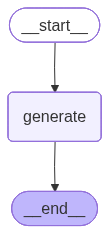

In [20]:

# AI 응답 생성 노드 - 확장된 상태 사용
def generate_response(state: ExtendedState) -> ExtendedState:
    # 대화 횟수 증가
    conversation_count = state.get("conversation_count", 0) + 1
    
    # 주제 추출 (간단한 예제)
    last_message = state["messages"][-1].content.lower()
    topic = "날씨" if "날씨" in last_message else "일반"
    print(f"Topic = {topic}")

    # 시스템 프롬프트 구성
    prompt = ChatPromptTemplate.from_messages([
        ("system", f"당신은 친절한 AI 어시스턴트입니다. (대화 #{conversation_count}, 주제: {topic})"),
        *state["messages"]
    ])
    
    # 응답 생성
    response = (prompt | llm).invoke({})
    
    # 상태 업데이트
    return {
        "messages": [response],
        "conversation_count": conversation_count,
        "last_topic": topic
    }

# 그래프 구성
graph_builder = StateGraph(ExtendedState)
graph_builder.add_node("generate", generate_response)
graph_builder.add_edge(START, "generate")
graph_builder.add_edge("generate", END)

app = graph_builder.compile()
app

In [28]:
# 실행
if __name__ == "__main__":
    query = input("질문을 입력해주세요")
    initial_state = {
        "messages": [HumanMessage(content=query)],
        "conversation_count": 0,
        "last_topic": ""
    }
    
    result = app.invoke(initial_state)
    print("대화 횟수:", result["conversation_count"])
    print("주제:", result["last_topic"])
    print("AI 응답:", result["messages"][-1].content)

Topic = 일반
대화 횟수: 1
주제: 일반
AI 응답: 현재 온도를 확인하려면 위치 정보가 필요합니다. 😊  

저는 실시간으로 날씨 데이터를 제공할 수 없지만, 다음과 같은 방법으로 확인할 수 있어요:  
1. **스마트폰 날씨 앱** (예: 날씨, AccuWeather)  
2. **인터넷 검색** (예: "서울 날씨" 또는 "현재 온도 [지역명]")  
3. **기상청 웹사이트**  

지역명을 알려주시면 대략적인 평균 기온이나 날씨 경향을 안내해 드릴 수도 있습니다! ☀️🌧️
